## Data extraction from a PDF table with semi-structured layout

### What is semi-structured data?

In today’s work environment PDF documents are widely used for exchanging business information, internally as well as with trading partners. Naturally, you’ve seen quite a lot of PDFs in the form of invoices, purchase orders, shipping notes, price-lists etc. Despite serving as a digital replacement of paper PDF documents present a challenge for automated manipulation with data they store. It is as accessible as data written on a piece of paper since some PDFs are designed to transfer information to us, humans, but not computers. Such PDFs can contain unstructured information that does not have a pre-defined data model or is not organized in a pre-defined manner. They are typically text-heavy and may contain a mix of figures, dates and numbers.

With the majority of available tools very often you have to process the entire PDF document, having no option to limit the data extraction to a specific section where the most valuable data lies in. However, some PDF table extraction tools do just that. Sad to say that even if you are lucky enough to have a table structure in your PDF it doesn’t mean that you will be able to seamlessly extract data from it.

In [1]:
%matplotlib inline

In [2]:
import tempfile
from io import StringIO
import tabula
import camelot
import pandas as pd
import numpy as np
import pdftotext
from PIL import Image, ImageFont, ImageDraw
from pdf2image import convert_from_path
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
import dataframe_image as dfi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
pd.set_option('display.max_colwidth', None)

After all necessary imports and settings are done we can take a look at the following PDF with some fake content. It has quite noticeable and distinguishing (although borderless) rows and columns:

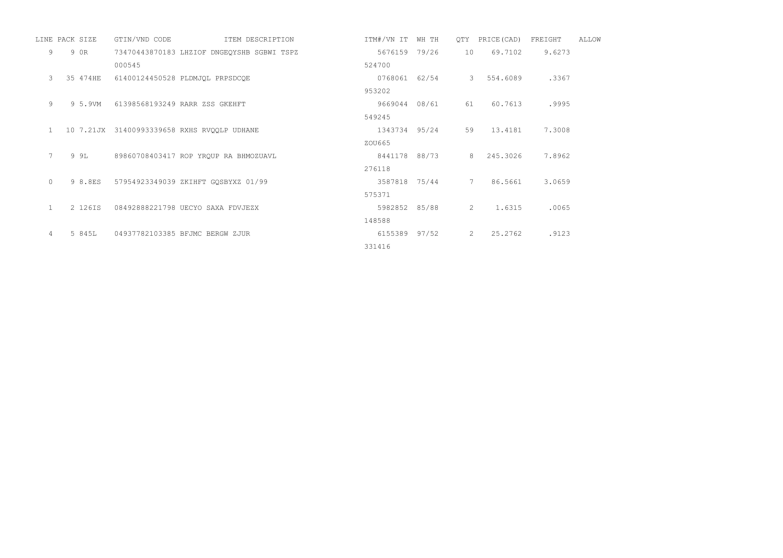

In [4]:
PDF = 'example_ready/example.pdf'
pdf_img = convert_from_path(PDF, dpi=300)[0]

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(pdf_img)

With only minor inspection you could have missed one important pattern: text at the intersection of some rows and columns is stacked and shifted so that it could hardly be recognized as the additional feature of the same data row.
Nonetheless, any data that does not fit nicely into a column or a row is widely considered unstructured, we can identify this particular real-world phenomenon as semi-structured data.
Which does not make it easier to parse data from a given table for any out-of-box extracting algorithm. While those tools may have reasonably efficient results, in this particular case we require extra development effort to fit your requirements. Moving forward with this tutorial you’ll find a non-trivial solution to this challenge.

### Scope of this tutorial

In this tutorial you will learn how to:
* use out-of-box solutions to extract tables from PDF
* get a raw text from PDF with the authentic document layout
* perform text manipulations with numpy and pandas
More generally you will get a sense of how to deal with context-specific data structures in a range of data extracting tasks.

### Out-of-box-solutions for table extraction

To proceed we need a few more helper functions to visualise the results of our work: 

In [5]:
def make_df_image(table,
                  max_cols=-1,
                  max_rows=-1):
    """Return dataframe as image."""
    with tempfile.NamedTemporaryFile(suffix='.jpg',
                                     delete=False) as tmp:
        dfi.export(table, tmp.name, max_cols=max_cols, max_rows=max_rows)
        image = mpimg.imread(tmp.name)
        return image


def make_lines_image(lines,
                     mrgn=15,
                     background=(255, 255, 255),
                     text_color=(0, 0, 0),
                     font_size=8):
    """Return raw text in lines as image."""
    lines = pd.Series(lines)
    longest_line = lines[lines.str.len().idxmax()]
    image = Image.new("RGBA", (1, 1))
    draw = ImageDraw.Draw(image)
    monospace = ImageFont.truetype(r'С:\Windows\Fonts\cour.ttf', font_size)
    line_width, line_height = draw.textsize(longest_line, monospace)
    img_width, img_height = (line_width + mrgn * 2,
                             len(lines) * line_height + mrgn * 2)
    image = Image.new("RGBA", (img_width, img_height), background)
    draw = ImageDraw.Draw(image)
    x, y0 = (mrgn, mrgn)
    for n, line in enumerate(lines):
        y = y0 + n * line_height
        draw.text((x, y), line, text_color, monospace)
    return image

To affirm the truth of the above statements we’ll try to parse our semi-structured data with ready-made Python modules, specially assigned to extract tables from PDFs. Among the most popular out-of-box algorithms are camelot-py and tabula-py. They both showed themselves to be effective in many complicated contexts. Let’s see how they meet our challenge:

In [6]:
tabula_df = (tabula
             .read_pdf(PDF,
                       stream=True,
                       pages="all"))


camelot_df = (camelot
              .read_pdf(PDF,
                        flavor="stream",
                        suppress_stdout=True,
                        pages="all")
              [0].df)

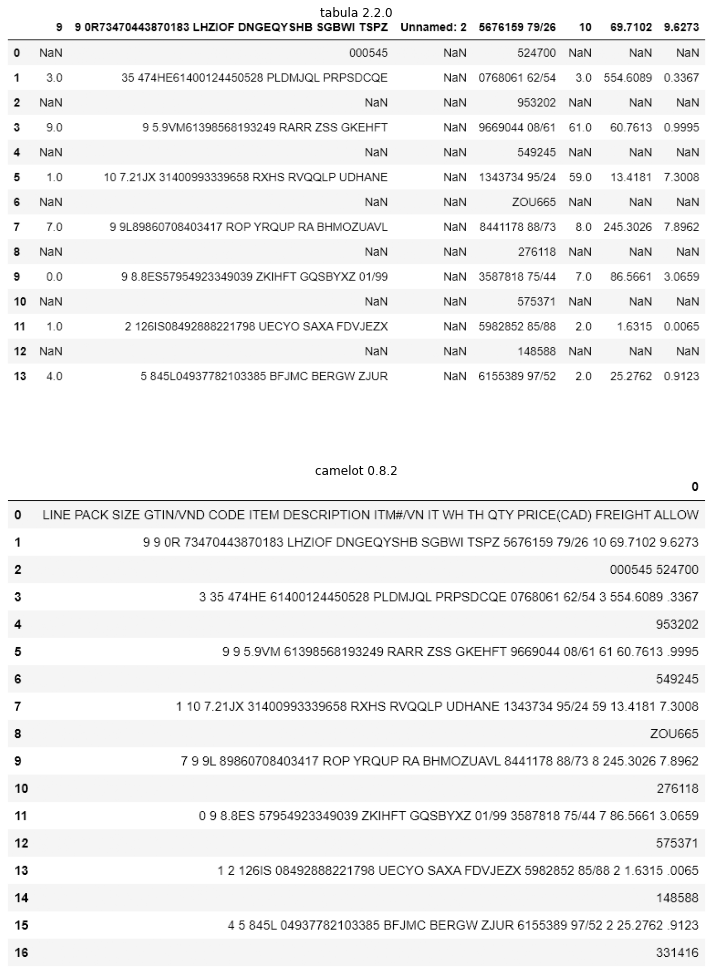

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))
titles = ['tabula 2.2.0', 'camelot 0.8.2']
for i, img in enumerate(map(make_df_image, [tabula_df, camelot_df])):
    ax[i].axis("off")
    ax[i].set_adjustable("box")
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img)
fig.tight_layout()

Seems like our initial choice has turned into a miserable failure! While tabula-py appears to be slightly better in detecting a grid layout of our table, it still provides a lot of extra work to split the text in a second column, not saying it has completely kicked off the last ‘hanging’ row of the original table. As to the output of camelot-py — it is obvious that all the relevant information about interposition of text in columns has completely vanished.

From this moment on, we’ll proceed with building our custom parsing algorithm.

### Processing raw text from PDF with authentic layout

To begin with, we need a basis for our custom algorithm to work on. This should be a string input, fully representing the layout of the original document. Again you have quite a few options (think of python modules) to choose from. In our tutorial, we'll decide on [pdfminer](https://pdfminersix.readthedocs.io/en/latest/) and [pdftotext](https://github.com/jalan/pdftotext) to experiment with. Here is the output of their work:

In [8]:
pdfminer_string = StringIO()
with open(PDF, "rb") as in_file:
    parser = PDFParser(in_file)
    doc = PDFDocument(parser)
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr,
                           pdfminer_string,
                           laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    for page in PDFPage.create_pages(doc):
        interpreter.process_page(page)
pdfminer_lines = pdfminer_string.getvalue().splitlines()
pdfminer_lines = [ln for ln in pdfminer_lines if ln]


with open(PDF, 'rb') as file:
    pdftotext_string = pdftotext.PDF(file)
pdftotext_lines = ("\n\n".join(pdftotext_string).splitlines())
pdftotext_lines = [ln for ln in pdftotext_lines if ln]

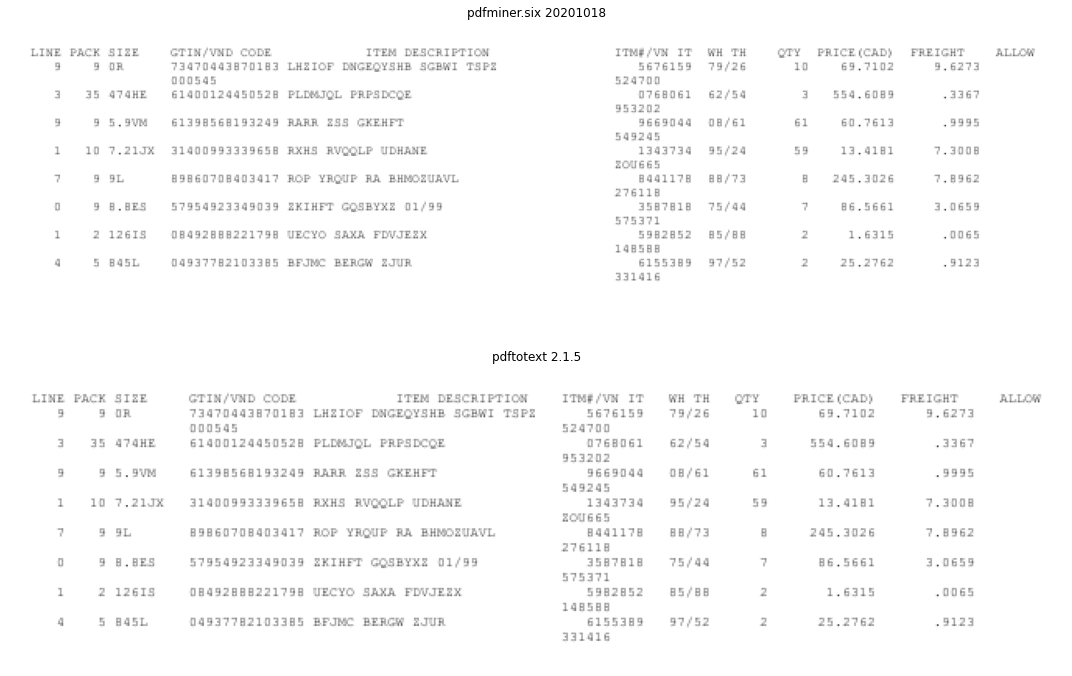

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
titles = ['pdfminer.six 20201018', 'pdftotext 2.1.5']
for i, img in enumerate(map(make_lines_image,
                            [pdfminer_lines, pdftotext_lines])):
    ax[i].axis("off")
    ax[i].set_adjustable("box")
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img)
fig.tight_layout()

It looks like both modules have produced quite satisfactory results, except for pdftotext has stripped some whitespace between 5th and 6th arbitrary columns. But the most essential is that in both cases we were able to preserve visible intervals between blocks of text aligned vertically (hello monospace font!)

### Manipuating text data with numpy and pandas

Another good news is that those blank spaces are somewhat that makes you perceive the vertically aligned text as a single whole element, i.e. a column in our table layout! This is a Law of Proximity in action. If you have never heard about Gestalt Theory of Visual Design before, please refer to the [link](https://www.creativebloq.com/graphic-design/gestalt-theory-10134960). What you should understand in particular is that the Law of Proximity is a long way off from any law of physics. It is just in your mind, so each time you have to explicitly tell a computer how close an arrangement of elements should be to have proximity. In our case, it is enough to have a straight vertical line of minimum one whitespace in width to evenly separate columns from each other. All we need is to show our custom algorithm where those whitespace-line dividers are.

#### Turning string input into char matrix

To do the trick we’ll turn our string output from pdfminer into a char matrix, i.e. a structure with each string element including whitespaces in their separate cells. With some helper functions in the following block of code we sequentially perform the transformation and searching for above-mentioned dividers:

In [10]:
def adjust_string(string, out_width):
    ''' Pad string with whitespaces to the right
    to make it of the same length as longest string in a series.
    Needed further to evenly split strings into columns on a divider
    such as empty vertical-wise string through all the rows '''
    fill_width = out_width - len(string)
    string += ' ' * fill_width
    return string

In [11]:
pdf_lines = pd.Series(pdfminer_lines)
max_width = pdf_lines.str.len().max()
pdf_lines_adjusted = pdf_lines.apply(adjust_string, args=(max_width, ))
pdf_lines_mtx = np.stack(pdf_lines_adjusted.map(list).to_numpy())


whitespace_сols = np.where(np.all(pdf_lines_mtx == ' ', axis=0))[0]
rightmost_whitespace_cols = np.where(np.diff(whitespace_сols) != 1)[0]
column_dividers = np.append(whitespace_сols[rightmost_whitespace_cols],
                            whitespace_сols[-1])

To visualise our results we'll temporarily turn our matrix into dataframe and have a lot of what we've got:

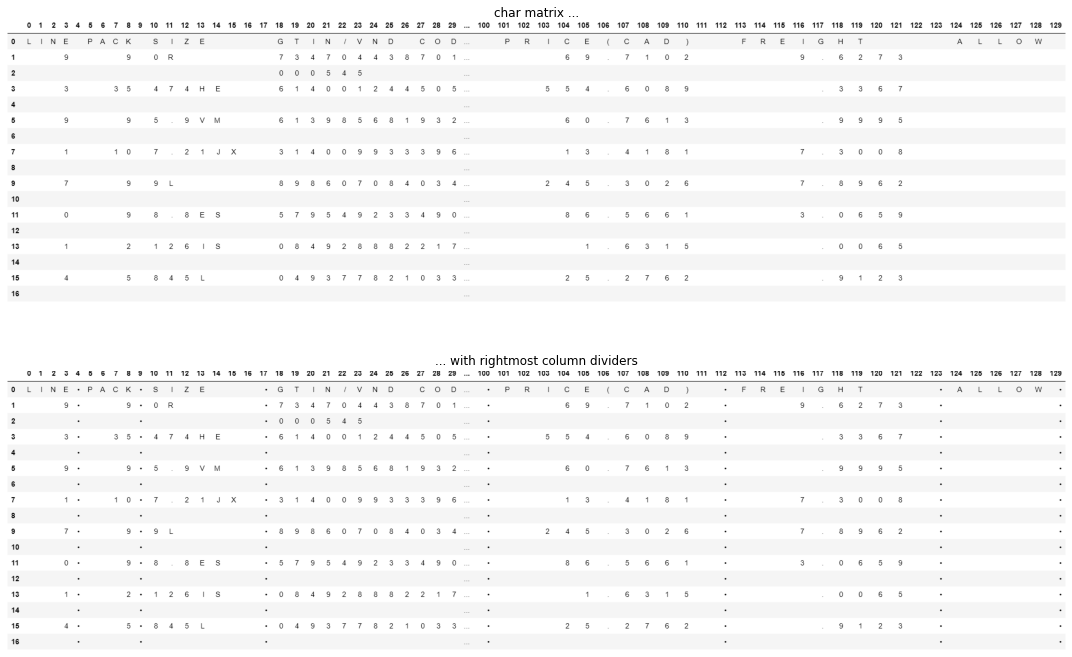

In [12]:
df_mtx = pd.DataFrame(pdf_lines_mtx)
df_mtx_w_dividers = df_mtx.copy()

df_mtx_w_dividers.loc[:, column_dividers] = (df_mtx_w_dividers[column_dividers]
                                             .replace({' ': '\u2022'}))

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
titles = ['char matrix ...', '... with rightmost column dividers']
for i, img in enumerate([make_df_image(d, max_cols=60)
                         for d in [df_mtx, df_mtx_w_dividers]]):
    ax[i].axis("off")
    ax[i].set_adjustable("box")
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img)
fig.tight_layout()

#### Splitting raw text into columns

Seems like we are ready to move forward and perform splitting of input lines into newly defined columns:

In [13]:
splitted_lines = []
for row in pdf_lines_adjusted:
    current_row = []
    for e in range(len(column_dividers) - 1):
        if e == 0:
            current_row.append(row[: column_dividers[e]].strip())
        (current_row
         .append(row[column_dividers[e]: column_dividers[e + 1]]
                 .strip()))
    current_row.append(row[column_dividers[-1]:].strip())
    splitted_lines.append(current_row)

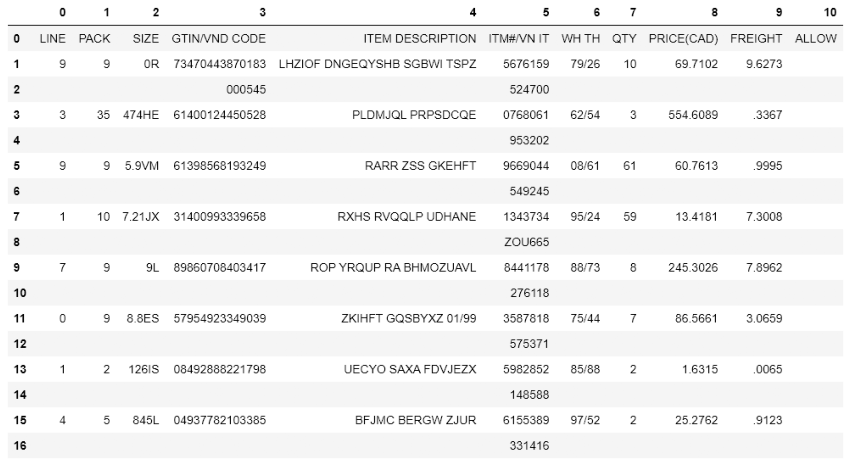

In [14]:
pdf_df = pd.DataFrame(splitted_lines)
empty_cols = (pdf_df == '').all()
pdf_df = pdf_df[pdf_df.columns[~empty_cols]]

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(make_df_image(pdf_df))

#### Dealing with stacked data in rows

Amazing! Our next step will be to move those stacked text-blocks within ‘hanging’ (even) rows to the right and up onto (⤴) the same level with a correspondent odd rows where they authentically belong to. Alongside we’ll separate the first row as the header of our table to deal with it individually:

In [15]:
header_row = pdf_df.iloc[0, :].copy()
table_rows = pdf_df.iloc[1:, :].copy()

odd_rows = table_rows.iloc[::2].copy()
odd_rows.reset_index(drop=True, inplace=True)

evn_rows = table_rows[1::2].copy()
evn_rows.reset_index(drop=True, inplace=True)

evn_rows.replace({'': np.nan}, inplace=True)
evn_rows.dropna(axis=1, how='all', inplace=True)

all_rows = pd.concat([odd_rows, evn_rows], axis=1, sort=True)
all_rows.sort_index(axis=1, inplace=True)
all_rows.columns = all_rows.columns.astype(str)
all_rows.reset_index(drop=True, inplace=True)
all_rows.replace({np.nan: ''}, inplace=True)

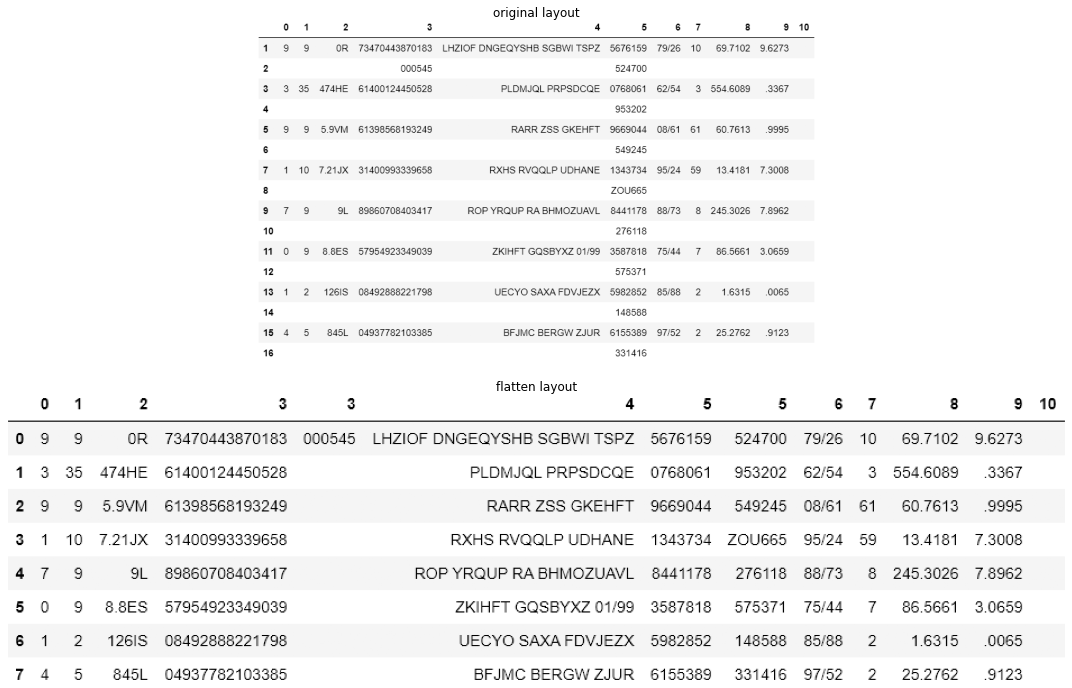

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
titles = ['original layout', 'flatten layout']
for i, img in enumerate(map(make_df_image, [table_rows, all_rows])):
    ax[i].axis("off")
    ax[i].set_adjustable("box")
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img)
fig.tight_layout()

#### Matching columns to original headers

Have you noticed how naturally and consistently our table got doubling headers for additional columns, such as 3–3 and 5–5? To further refer all the columns to original headers of the table we’ll perform the following renaming trick: we’ll assign all the doubling entries new unique subtitles (postfixes) respect to their parent (leftmost) elements. Such as a sequence [0, 1, 2, 3, 3, 4 …] will become [0, 1, 2, 3, 3_1, 4 …].

In [17]:
def add_postfix_after(in_list):
    """Rename duplicates in a given list.
    
    in:
        print(add_postfix_after([0, 1, 2, 2, 3, 3, 3, 4, 5, 6, 6]))
    out:
        ['0', '1', '2', '2_1', '3', '3_1', '3_2', '4', '5', '6', '6_1']
    Needed to further compare list of columns with added ones to the
    index of original columns.
    """
    out_list = []
    x = 0
    while x < len(in_list) - 1:
        if in_list[x] != in_list[x + 1]:
            out_list.append(str(in_list[x]))
            x += 1
        else:
            out_list.append(str(in_list[x]))
            y = 1
            while x + y < len(in_list):
                if in_list[x] == in_list[x + y]:
                    out_list.append("{}_{}".format(in_list[x], y))
                    y += 1
                else:
                    break
            x += y
    if x == len(in_list) - 1:
        out_list.append(str(in_list[-1]))
    return out_list

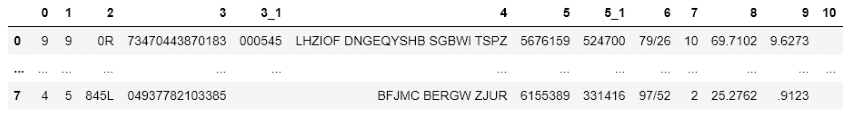

In [18]:
all_rows.columns = add_postfix_after(all_rows.columns.astype(int).tolist())

plt.figure(figsize=(15, 5))
plt.axis('off')
plt.imshow(make_df_image(all_rows, max_rows=3))

The somewhat similar transformation we’ll perform on original headers of the table (being separated from data on the previous step). It is assumed you have already noticed one particular pattern there: all the columns with stacked text have ‘/’ in their titles, which denotes the name of a column we’ve got from data unstacking. To match columns with their titles we need some kind of a lookup table for headers to refer to and perform the final touch:

In [19]:
header_splitted = header_row.str.split('/')

header_indicies = []
for i, element in enumerate(header_splitted):
    if len(element) == 1:
        header_indicies.append(str(i))
    else:
        for j, w in enumerate(element):
            if j == 0:
                header_indicies.append(str(i))
            else:
                header_indicies.append('{}_{}'.format(i, j))

header_elements = [item for sublist in header_splitted
                   for item in sublist]

column_names = pd.Series(data=header_elements,
                         index=header_indicies)

print(column_names)

0                  LINE
1                  PACK
2                  SIZE
3                  GTIN
3_1            VND CODE
4      ITEM DESCRIPTION
5                  ITM#
5_1               VN IT
6                 WH TH
7                   QTY
8            PRICE(CAD)
9               FREIGHT
10                ALLOW
dtype: object


In [20]:
all_rows.columns = column_names[all_rows.columns]

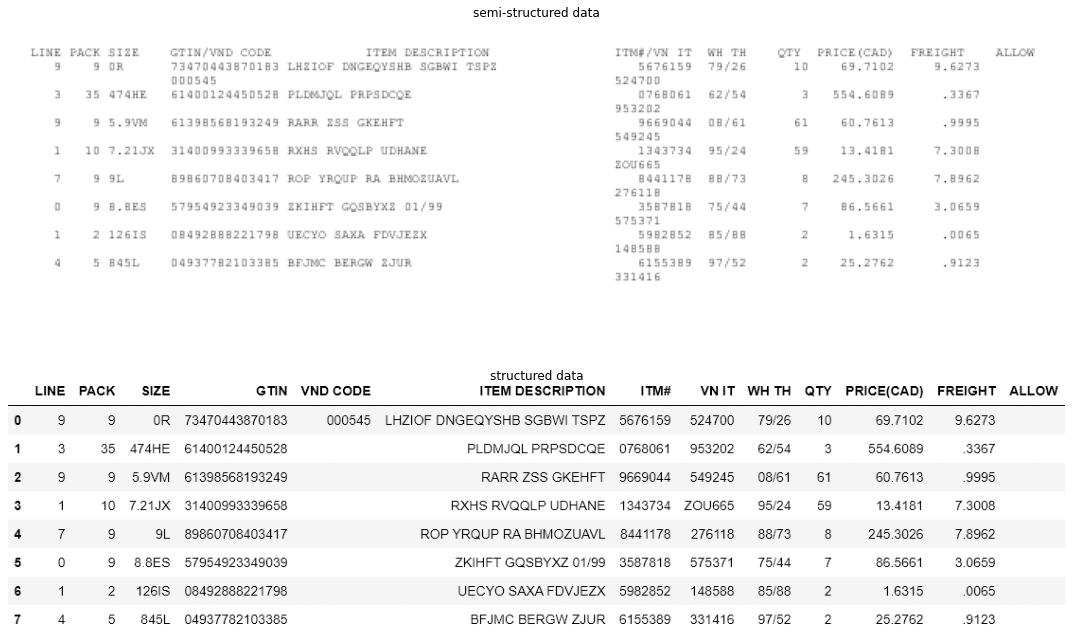

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
titles = ['semi-structured data', 'structured data']
for i, img in enumerate([make_lines_image(pdfminer_lines),
                         make_df_image(all_rows)]):
    ax[i].axis("off")
    ax[i].set_adjustable("box")
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img)
fig.tight_layout()